# HOMEWORK 2 (BIFLOW) - Network Measurement and Data Analysis Lab

*Stefano Maxenti, 10526141, 970133*

### Index

[LIBRARIES AND FUNCTIONS](#libraries_and_functions)

[CURL](#biflow_features_curl)

[FIREFOX](#biflow_features_firefox)

[CONCLUSIONS](#conclusions)

## Libraries and functions
<a id='libraries_and_functions'></a>

In this first section, I import various needed libraries and define some useful functions which are used in the code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join, splitext
import statistics
from cyberpandas import IPArray, to_ipaddress

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import  classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from scipy.interpolate import interp1d
import joblib # this library is useful to save objects to the drive and to load them again

In [2]:
# It encodes categorical labels to numerical values and returns the dataset with only values as well
def label_encoding(dataset):
    le = LabelEncoder();
    X = dataset.dropna();
    Y = le.fit_transform(X['website']);
    X = X.drop(['website'],axis=1);
    return X, Y, le

# It normalizes values using a standard scaler: X = (X-mean)/std. It returns the scaler as well for transforming the test dataset
def normalization(X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, scaler

In [3]:
# This is the requested K-NN classifier. Plot and verbose are flags used to determine how much output to show
def knn_classifier(X_train, Y_train, X_test, Y_test, plot=False, verbose=False):
    accuracy_list = []
    knn_list = []
    for k in range(1, 11):
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        knn.fit(X_train, Y_train)
        accuracy = knn.score(X_test, Y_test)
        accuracy_list.append(accuracy)
        knn_list.append(knn)
        if (verbose):
            print("k = ", k , ": accuracy = ", accuracy)
    best_accuracy = max(accuracy_list)
    k = accuracy_list.index(max(accuracy_list))+1
    if (verbose):
        print("Best result is ", best_accuracy, 
          " obtained with k = ", k)
    if (plot):
        plt.xticks(np.arange(1,11,1))
        plt.plot(np.arange(1,11,1), accuracy_list)
        plt.grid(visible=True)
        plt.ylabel('Accuracy')
        plt.xlabel('K')
    return knn_list[k-1]

In [4]:
# A very basic random forest classifier
def random_forest_classifier(X_train, Y_train, X_test, Y_test, verbose=False):
    rf = RandomForestClassifier()
    rf.fit(X_train, Y_train)
    rf_accuracy = rf.score(X_test, Y_test)
    if (verbose):
        print("Accuracy: ", rf_accuracy)
    return rf

In [5]:
# A very basic multi-layer-perceptron for deep learning
# In order to keep the training and testing codes of models as consistent as possible, 
# I keep only the deep learning implementation from Sklearn and not the more powerful one from Keras/Tensorflow.
# Results between SK and TF prove to be similar, even though in Sklearn it is not possible to apply 
# advanced regularization technique such as dropout, Glorot initialization and reduction of learning rate on plateau.
def multi_layer_perceptron_classifier(X_train, Y_train, X_test, Y_test, verbose=False):
    mlp = MLPClassifier(random_state=1, solver='adam',  # adam optimizer for the gradient descent
                        learning_rate_init=1e-4, # initial learning rate
                        hidden_layer_sizes=(128, 64), # two fully connected hidden layers with 128 and 64 neurons each
                        max_iter=1000, # maximum number of epochs to train
                        early_stopping=True, # to avoid overfitting, I keep 10% of the training data as validation set
                        n_iter_no_change=30, # validation loss is monitored for 30 epochs before stopping
                        batch_size=8) # the gradient is updated every 8 samples.
    mlp.fit(X_train, Y_train)
    mlp_accuracy = mlp.score(X_test, Y_test)
    if (verbose):
        print("FINAL ACCURACY: ", mlp_accuracy)
    return mlp

In [6]:
# A Support Vector Machine classifier, built with the same c and gamma values as the suggested paper.
def svm_classifier(X_train, Y_train, X_test, Y_test, verbose=False):
    gamma = [2**-3, 2**-1, 2, 2**3]
    c = [2**11, 2**13, 2**15, 2**17]
    svm_list = []
    accuracy_list = [] 
    i = 0
    for c_ in c:
        for g in gamma:
            svm = SVC(gamma=g, C=c_)
            svm.fit(X_train, Y_train)
            svm_list.append(svm)
            svm_accuracy = svm.score(X_test, Y_test)
            accuracy_list.append(svm_accuracy)
            if (verbose):
                print("Accuracy with c =", c_, "and gamma =", g,":", svm_accuracy)
            i += 1
    best_accuracy = max(accuracy_list)
    k = accuracy_list.index(max(accuracy_list))
    best_model = svm_list[k]
    if (verbose):
        print('Best accuracy ', best_accuracy, 'with C = ', best_model.get_params()['C'], 'and gamma = ', best_model.get_params()['gamma'])
    return best_model

In [7]:
# A generic function to test the accuracy and to plot the confusion matrix
def model_test(model, X_test, Y_test):
    model_predict = model.predict(X_test)
    model_report = classification_report(Y_test,model_predict,target_names=le.inverse_transform(np.arange(len(websites))),digits=3,output_dict=True, zero_division=0)
    fold_accuracy = model_report['accuracy']
    print("On the test set: accuracy =", fold_accuracy)
    fig, ax = plt.subplots(figsize=(8, 8));
    ConfusionMatrixDisplay.from_predictions(model_predict, Y_test, xticks_rotation=-90, ax=ax, display_labels=le.inverse_transform(np.arange(len(websites))));

Biflow approach

In [8]:
def extract_features(df_flow):
    #compute flow features:
    flow_features = {}
    # for simplicity, we assume that the client, in the uplink direction, uses a private IP, whereas the server is always public
    df_up = df_flow[to_ipaddress(df_flow['ip.src']).is_private == True]
    df_down = df_flow[to_ipaddress(df_flow['ip.src']).is_private == False]

    flow_features['num_packets_up'] = len(df_up)
    flow_features['num_packet_down'] = len(df_down)
    
    pkt_sizes = df_up['ip.len'].astype(float)
    flow_features['total_bytes_up'] = pkt_sizes.sum()
    flow_features['min_pkt_size_up'] = pkt_sizes.min() 
    flow_features['max_pkt_size_up'] = pkt_sizes.max()
    flow_features['mean_pkt_size_up'] = pkt_sizes.mean()
    flow_features['std_pkt_size_up'] = pkt_sizes.std()

    pkt_sizes = df_down['ip.len'].astype(float)
    flow_features['total_bytes_down'] = pkt_sizes.sum()
    flow_features['min_pkt_size_down'] = pkt_sizes.min() 
    flow_features['max_pkt_size_down'] = pkt_sizes.max()
    flow_features['mean_pkt_size_down'] = pkt_sizes.mean()
    flow_features['std_pkt_size_down'] = pkt_sizes.std()

    iat = pd.to_datetime(df_up['frame.time']).diff(1).dt.total_seconds().iloc[1:] #
    flow_features['min_iat_up'] = iat.min()
    flow_features['max_iat_up'] = iat.max()
    flow_features['mean_iat_up'] = iat.mean()
    flow_features['std_iat_up'] = iat.std()

    iat = pd.to_datetime(df_down['frame.time']).diff(1).dt.total_seconds().iloc[1:] #
    flow_features['min_iat_dowj'] = iat.min()
    flow_features['max_iat_down'] = iat.max()
    flow_features['mean_iat_down'] = iat.mean()
    flow_features['std_iat_down'] = iat.std()
    #flow_features['dur'] = iat.sum()
    return flow_features

In [9]:
def import_csv_biflow(path):
    tcpdumpfiles = [f for f in listdir(path) if (isfile(join(path, f)) and splitext(join(path,f))[-1] == '.csv')]
    websites = np.unique([f.split('-')[0] for f in tcpdumpfiles])

    dataset = pd.DataFrame()
    print("Processing files...")
    i = 1
    l = len(tcpdumpfiles)
    old_percent = 0
    for f in tcpdumpfiles:
        try:
            ### these lines provide a quick indication on the importing progress
            percent = int(100*i/l)
            if (percent % 5 == 0 and percent != old_percent):
                print("{0:.0%}".format(percent/100), end= " ")
                old_percent = percent
            i += 1
            ###
            df = pd.read_csv(join(path,f))
            flow_features = extract_features(df)
            flow_features['website'] = f.split('-')[0];
            dataset = dataset.append(flow_features,ignore_index=True);
        except:
            print(f, " was not added to the dataset. Probably corrupted.")
    return dataset

## Biflow features - curl

<a id='biflow_features_curl'></a>

In [ ]:
#!wget "https://polimi365-my.sharepoint.com/:u:/g/personal/10526141_polimi_it/ESh0NZOxC0dIpDwOWonGPDEB2kKhmdznvfuSADRS7_kdxA?download=1" -O "input/CSV_curl.zip"
#!unzip "input/CSV_curl.zip" -d "input/"

In [ ]:
dataset = import_csv_biflow('input/CSV_curl')
dataset.to_csv('input/DS_biflow_curl.csv', index=False)
websites = np.unique(dataset['website'])

In [18]:
# To load...
dataset = pd.read_csv('input/DS_biflow_curl.csv')
websites = np.unique(dataset['website'])
dataset

,num_packets_up,num_packet_down,total_bytes_up,min_pkt_size_up,max_pkt_size_up,mean_pkt_size_up,std_pkt_size_up,total_bytes_down,min_pkt_size_down,max_pkt_size_down,...,std_pkt_size_down,min_iat_up,max_iat_up,mean_iat_up,std_iat_up,min_iat_dowj,max_iat_down,mean_iat_down,std_iat_down,website
0,70,96,4546.0,40.0,569.0,64.942857,64.503654,674867.0,52.0,30460.0,...,7740.201466,0.000002,0.008131,0.001027,0.001503,0.000001,0.010523,0.000723,0.001632,indiatimes.com
1,104,310,6291.0,40.0,569.0,60.490385,52.479121,1864059.0,52.0,35108.0,...,5416.097651,0.000003,0.014541,0.001305,0.002197,0.000002,0.026416,0.000429,0.001793,nytimes.com
2,115,146,7586.0,40.0,569.0,65.965217,69.101366,854359.0,52.0,33356.0,...,7608.766184,0.000002,0.529271,0.007744,0.050104,0.000003,0.483132,0.005905,0.040894,finance.yahoo.com
3,140,321,8153.0,40.0,569.0,58.235714,45.136501,1861260.0,52.0,34804.0,...,5809.727961,0.000004,0.483189,0.004937,0.040976,0.000001,0.480919,0.002137,0.026948,dailymail.co.uk
4,73,172,4702.0,40.0,569.0,64.410959,63.198505,676465.0,52.0,10188.0,...,2314.156952,0.000003,0.095593,0.002507,0.011333,0.000001,0.093222,0.001042,0.007395,indiatimes.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919,22,30,1913.0,40.0,557.0,86.954545,111.558858,44081.0,40.0,8270.0,...,2126.856406,0.000016,0.126910,0.011449,0.029411,0.000004,0.120965,0.008095,0.024508,msn.com
8920,236,239,13922.0,40.0,569.0,58.991525,48.694182,520025.0,52.0,8740.0,...,1458.432410,0.000002,0.784785,0.004854,0.051407,0.000002,0.757187,0.004681,0.049355,news.yahoo.com
8921,105,283,6343.0,40.0,569.0,60.409524,52.232781,1690115.0,52.0,49284.0,...,6206.146902,0.000006,0.007560,0.001139,0.001312,0.000002,0.009496,0.000413,0.001032,nytimes.com
8922,111,279,6657.0,40.0,569.0,59.972973,50.581071,1727261.0,52.0,33356.0,...,6024.467613,0.000003,0.224642,0.003321,0.021474,0.000001,0.222357,0.001306,0.013483,dailymail.co.uk


We pre-process data to feed our classifiers using sklearn tools

In [19]:
X, Y, le = label_encoding(dataset)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)
X_train, scaler = normalization(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, 'output_models/scaler_c1')

['output_models/scaler_c1']

k =  1 : accuracy =  0.9178491411501121
k =  2 : accuracy =  0.9178491411501121
k =  3 : accuracy =  0.9085138162808065
k =  4 : accuracy =  0.9159820761762509
k =  5 : accuracy =  0.9100074682598954
k =  6 : accuracy =  0.9137415982076176
k =  7 : accuracy =  0.909260642270351
k =  8 : accuracy =  0.9088872292755787
k =  9 : accuracy =  0.9040328603435399
k =  10 : accuracy =  0.9036594473487677
Best result is  0.9178491411501121  obtained with k =  1
On the test set: accuracy = 0.9178491411501121


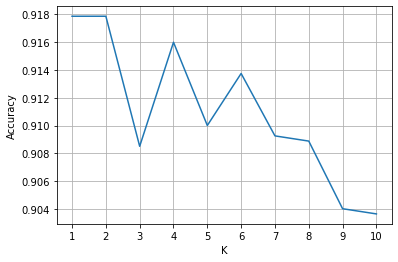

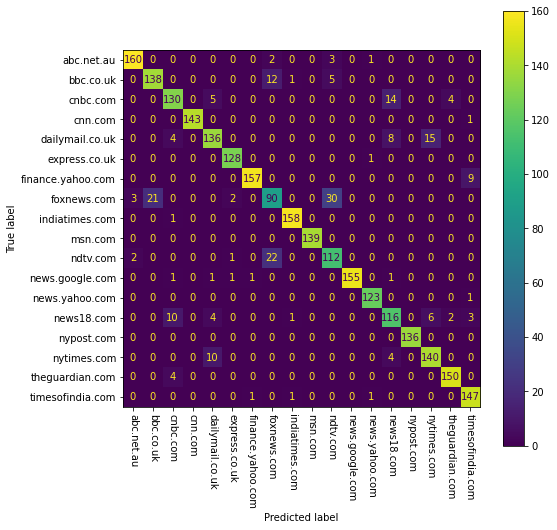

In [20]:
#knn_c1 = joblib.load('output_models/knn_c1.sav')
knn_c1 = knn_classifier(X_train, Y_train, X_test, Y_test, plot=True, verbose=True)
joblib.dump(knn_c1, "output_models/knn_c1.sav")
model_test(knn_c1, X_test, Y_test)

On the test set: accuracy = 0.9891710231516057


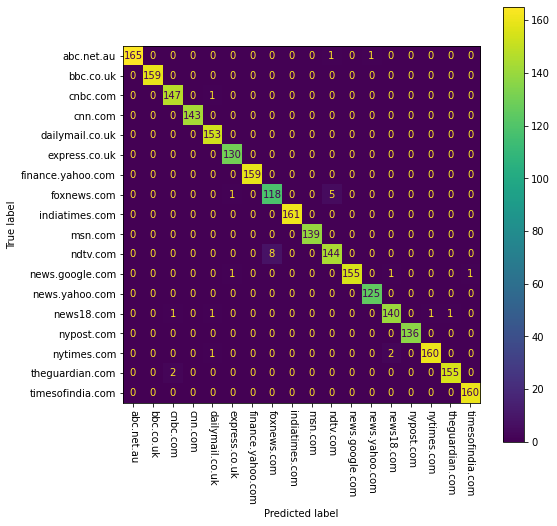

In [21]:
#rf_c1 = joblib.load('output_models/rf_c1.sav')
rf_c1 = random_forest_classifier(X_train, Y_train, X_test, Y_test)
joblib.dump(rf_c1, "output_models/rf_c1.sav")
model_test(rf_c1, X_test, Y_test)

On the test set: accuracy = 0.9783420463032113


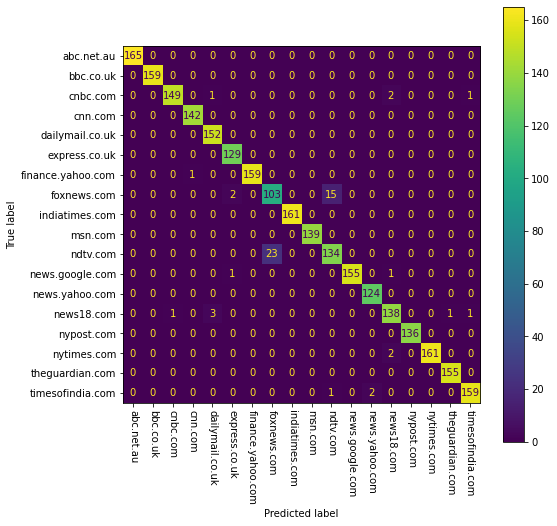

In [22]:
#mlp_c1 = joblib.load("output_models/mlp_c1.sav")
mlp_c1 = multi_layer_perceptron_classifier(X_train, Y_train, X_test, Y_test)
joblib.dump(mlp_c1, "output_models/mlp_c1.sav")
model_test(mlp_c1, X_test, Y_test)

Accuracy with c = 2048 and gamma = 0.125 : 0.977595220313667
Accuracy with c = 2048 and gamma = 0.5 : 0.9656460044809559
Accuracy with c = 2048 and gamma = 2 : 0.9156086631814787
Accuracy with c = 2048 and gamma = 8 : 0.8047050037341299
Accuracy with c = 8192 and gamma = 0.125 : 0.9783420463032113
Accuracy with c = 8192 and gamma = 0.5 : 0.9604182225541449
Accuracy with c = 8192 and gamma = 2 : 0.9159820761762509
Accuracy with c = 8192 and gamma = 8 : 0.8047050037341299
Accuracy with c = 32768 and gamma = 0.125 : 0.9779686333084391
Accuracy with c = 32768 and gamma = 0.5 : 0.9634055265123226
Accuracy with c = 32768 and gamma = 2 : 0.9159820761762509
Accuracy with c = 32768 and gamma = 8 : 0.8047050037341299
Accuracy with c = 131072 and gamma = 0.125 : 0.9761015683345781
Accuracy with c = 131072 and gamma = 0.5 : 0.9634055265123226
Accuracy with c = 131072 and gamma = 2 : 0.9159820761762509
Accuracy with c = 131072 and gamma = 8 : 0.8047050037341299
Best accuracy  0.9783420463032113 wit

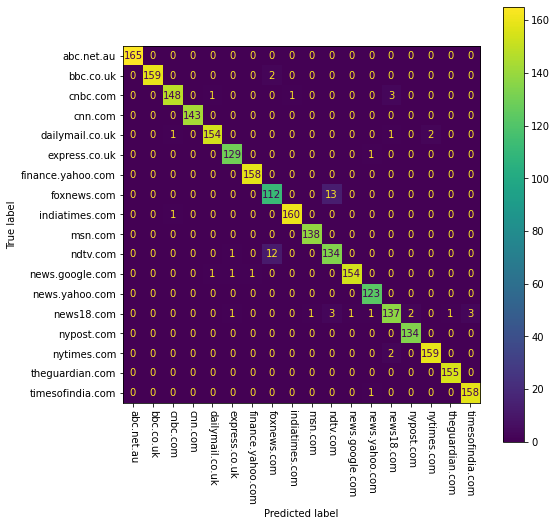

In [23]:
#svm_c1 = joblib.load("output_models/svm_c1.sav")
svm_c1 = svm_classifier(X_train, Y_train, X_test, Y_test, verbose=True)
joblib.dump(svm_c1, "output_models/svm_c1.sav")
model_test(svm_c1, X_test, Y_test)

Now we move to testing in different days. Let's load the model and, if necessary, download the complete CSVs before pre-processing.

In [10]:
knn_c1 = joblib.load('output_models/knn_c1.sav')
rf_c1 = joblib.load('output_models/rf_c1.sav')
mlp_c1 = joblib.load('output_models/mlp_c1.sav')
svm_c1 = joblib.load('output_models/svm_c1.sav')

scaler = joblib.load('output_models/scaler_c1')

In [ ]:
#!wget "https://polimi365-my.sharepoint.com/:u:/g/personal/10526141_polimi_it/EcstXWzLgIlPokDeauhr8-0BHjgNxKav7jzx0oDqiA6f-Q?download=1" -O "TEST/curl.zip"
#!unzip "TEST/curl.zip" -d "TEST/"




K-NN:  On the test set: accuracy = 0.9018518518518519
RF:    On the test set: accuracy = 0.9703703703703703
MLP:   On the test set: accuracy = 0.9592592592592593
SVM:   On the test set: accuracy = 0.9555555555555556


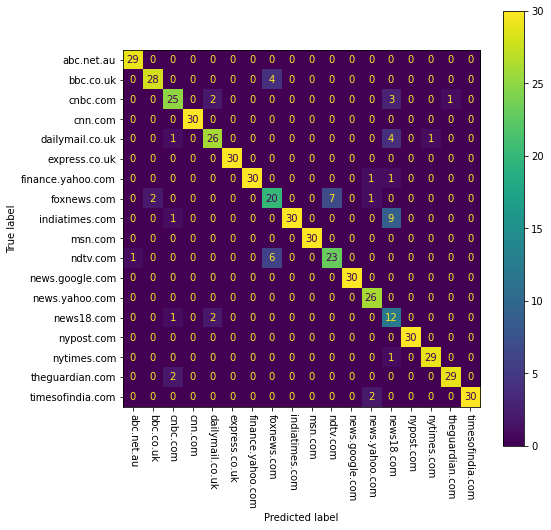

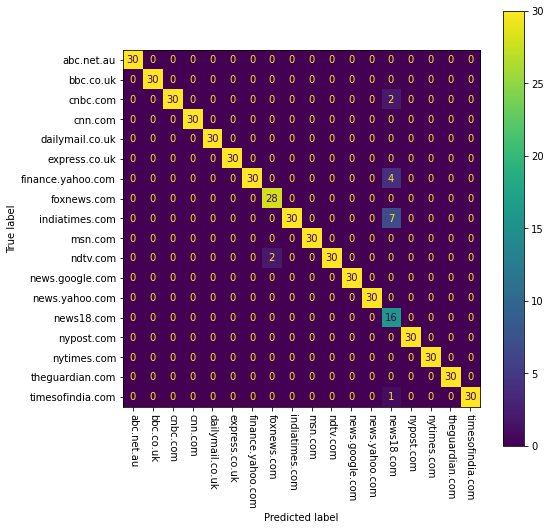

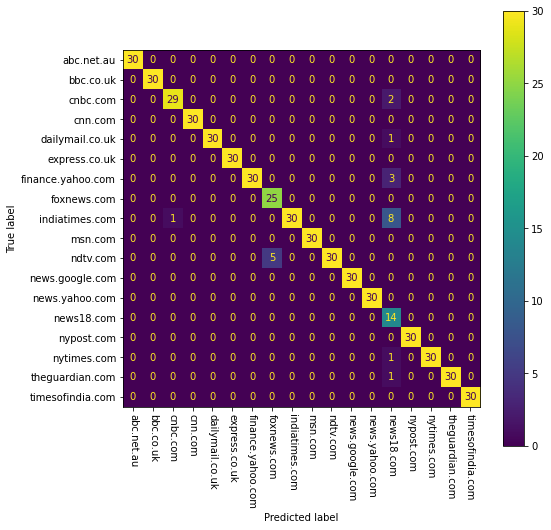

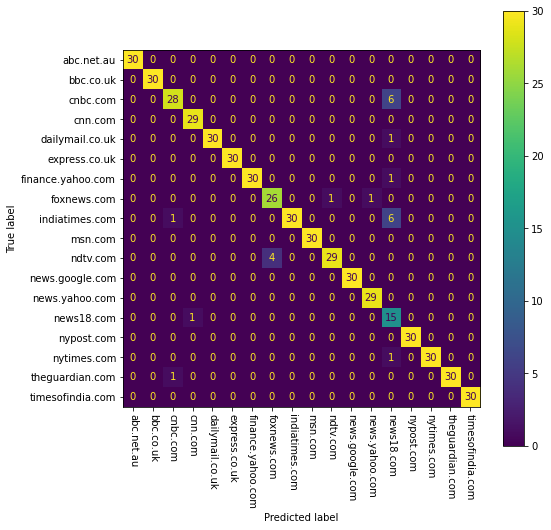

In [24]:
# 1 day later
#dataset = import_csv_biflow('TEST/curl/1DAY')
#dataset.to_csv('TEST/test_biflow_curl_1day.csv', index=False)
dataset = pd.read_csv('TEST/test_biflow_curl_1day.csv')
websites = np.unique(dataset['website'])

X_norm, Y, le = label_encoding(dataset)
X_norm = scaler.transform(X_norm)

print("\n\n")

print("K-NN: ", end = " ")
model_test(knn_c1, X_norm, Y)
print("RF:   ", end = " ")
model_test(rf_c1, X_norm, Y)
print("MLP:  ", end = " ")
model_test(mlp_c1, X_norm, Y)
print("SVM:  ", end = " ")
model_test(svm_c1, X_norm, Y)




K-NN:  On the test set: accuracy = 0.8690476190476191
RF:    On the test set: accuracy = 0.9146825396825397
MLP:   On the test set: accuracy = 0.9246031746031746
SVM:   On the test set: accuracy = 0.9265873015873016


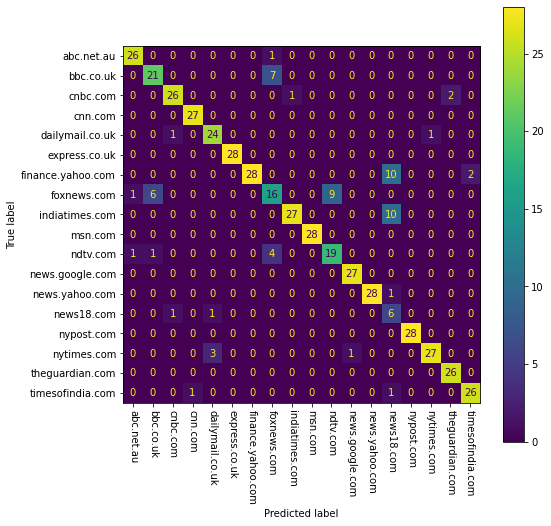

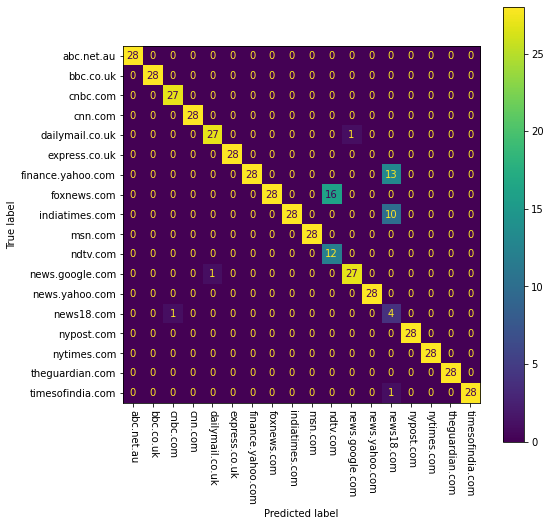

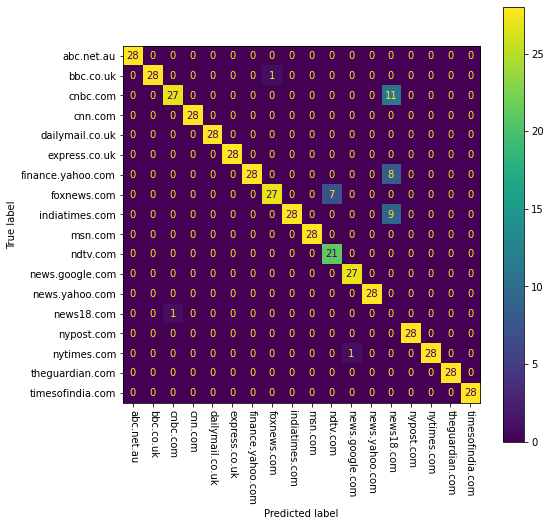

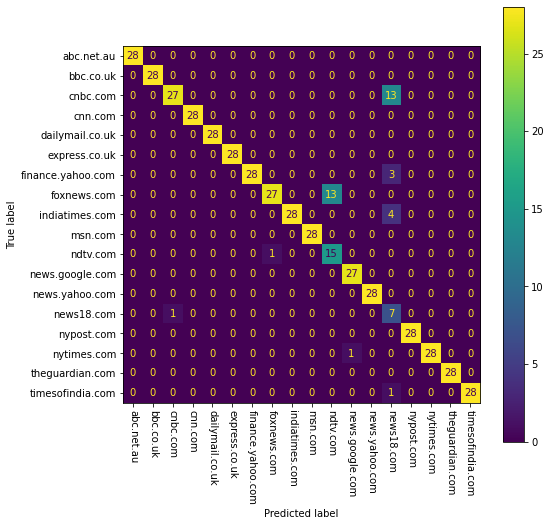

In [25]:
# 3 days later
#dataset = import_csv_biflow('TEST/curl/3DAYS')
#dataset.to_csv('TEST/test_biflow_curl_3days.csv', index=False)
dataset = pd.read_csv('TEST/test_biflow_curl_3days.csv')
websites = np.unique(dataset['website'])

X_norm, Y, le = label_encoding(dataset)
X_norm = scaler.transform(X_norm)

print("\n\n")

print("K-NN: ", end = " ")
model_test(knn_c1, X_norm, Y)
print("RF:   ", end = " ")
model_test(rf_c1, X_norm, Y)
print("MLP:  ", end = " ")
model_test(mlp_c1, X_norm, Y)
print("SVM:  ", end = " ")
model_test(svm_c1, X_norm, Y)




K-NN:  On the test set: accuracy = 0.8632478632478633
RF:    On the test set: accuracy = 0.8974358974358975
MLP:   On the test set: accuracy = 0.9166666666666666
SVM:   On the test set: accuracy = 0.9188034188034188


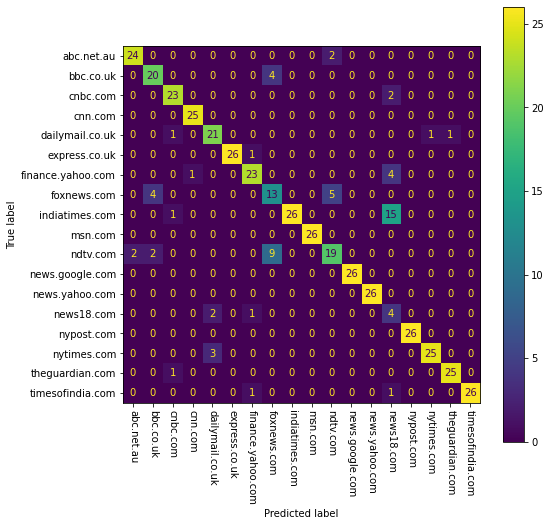

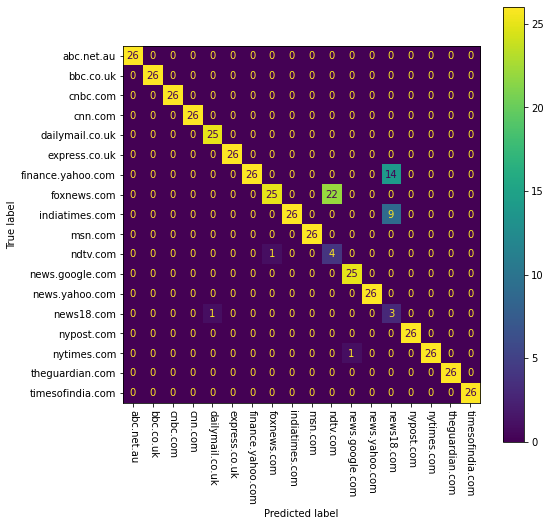

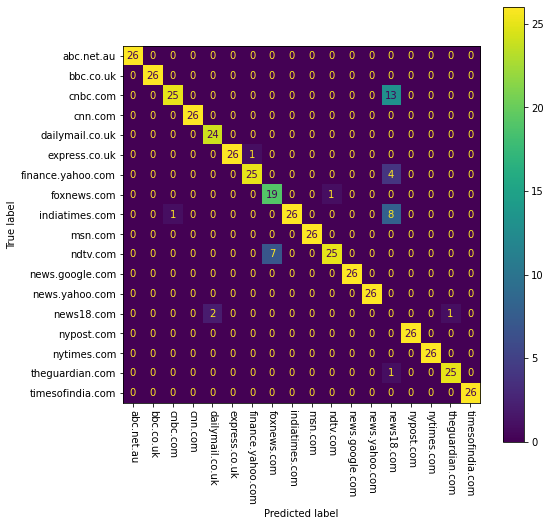

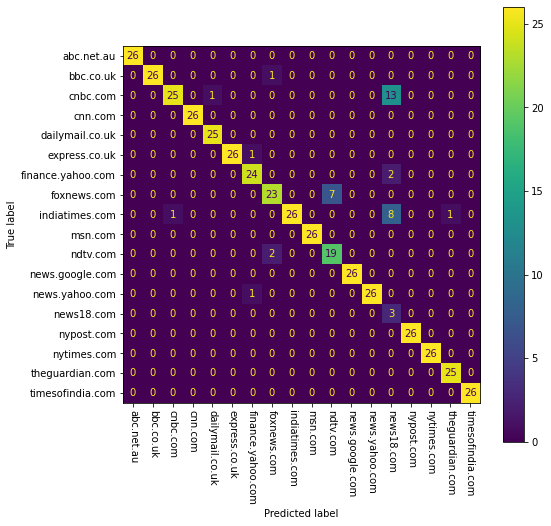

In [26]:
# 7 days later
#dataset = import_csv_biflow('TEST/curl/7DAYS')
#dataset.to_csv('TEST/test_biflow_curl_7days.csv', index=False)
dataset = pd.read_csv('TEST/test_biflow_curl_7days.csv')
websites = np.unique(dataset['website'])

X_norm, Y, le = label_encoding(dataset)
X_norm = scaler.transform(X_norm)

print("\n\n")

print("K-NN: ", end = " ")
model_test(knn_c1, X_norm, Y)
print("RF:   ", end = " ")
model_test(rf_c1, X_norm, Y)
print("MLP:  ", end = " ")
model_test(mlp_c1, X_norm, Y)
print("SVM:  ", end = " ")
model_test(svm_c1, X_norm, Y)

## Biflow features - firefox

<a id='biflow_features_firefox'></a>

In [ ]:
#!wget "https://polimi365-my.sharepoint.com/:u:/g/personal/10526141_polimi_it/EWis4276qyJDqaTRBAAlhTcB0gA0k1HFDV25gnbM3syAWg?download=1" -O "input/CSV_firefox.zip"
#!unzip "input/CSV_firefox.zip" -d "input/"

In [ ]:
dataset = import_csv_biflow('input/CSV_firefox')
dataset.to_csv('input/DS_biflow_firefox.csv', index=False)
websites = np.unique(dataset['website'])

In [10]:
# To load...
dataset = pd.read_csv('input/DS_biflow_firefox.csv')
websites = np.unique(dataset['website'])
dataset

,num_packets_up,num_packet_down,total_bytes_up,min_pkt_size_up,max_pkt_size_up,mean_pkt_size_up,std_pkt_size_up,total_bytes_down,min_pkt_size_down,max_pkt_size_down,...,std_pkt_size_down,min_iat_up,max_iat_up,mean_iat_up,std_iat_up,min_iat_dowj,max_iat_down,mean_iat_down,std_iat_down,website
0,250,251,38430.0,40.0,1618.0,153.720000,303.386908,488613.0,40.0,21940.0,...,4020.618913,0.000004,8.840662,0.073088,0.684484,0.000000,8.841036,0.072776,0.683146,abc.net.au
1,567,537,120303.0,40.0,1923.0,212.174603,366.520488,756995.0,40.0,35080.0,...,4467.411645,0.000005,5.381619,0.029449,0.283093,0.000001,13.614210,0.031093,0.588023,nytimes.com
2,438,400,74994.0,40.0,1385.0,171.219178,314.620228,1285459.0,40.0,64280.0,...,8470.490893,0.000005,8.754726,0.044544,0.493322,0.000001,17.099172,0.048780,0.855958,dailymail.co.uk
3,530,897,925634.0,40.0,19020.0,1746.479245,3870.567572,639645.0,40.0,32368.0,...,2741.981262,0.000005,6.081037,0.035348,0.294203,0.000000,6.080778,0.020863,0.288621,news.google.com
4,658,619,107241.0,40.0,1385.0,162.980243,281.276155,582945.0,40.0,10255.0,...,1906.436817,0.000001,5.087618,0.026890,0.228158,0.000001,5.088568,0.028583,0.266810,cnn.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271,102,97,12625.0,40.0,1140.0,123.774510,182.561310,54167.0,40.0,7725.0,...,1325.925831,0.000009,17.518716,0.192435,1.742129,0.000001,17.518768,0.202428,1.787014,dailymail.co.uk
2272,829,844,150689.0,40.0,3134.0,181.772014,365.757909,1331641.0,40.0,34540.0,...,4465.504679,0.000001,5.982136,0.022133,0.252993,0.000000,5.984744,0.021732,0.250920,finance.yahoo.com
2273,933,868,151535.0,40.0,1943.0,162.416935,289.321574,967896.0,40.0,41540.0,...,3501.126405,0.000005,4.403692,0.018476,0.178294,0.000001,9.102337,0.019858,0.316175,ndtv.com
2274,680,1016,879040.0,40.0,23235.0,1292.705882,3896.644078,1926105.0,40.0,49411.0,...,5368.147337,0.000004,6.792233,0.028501,0.281161,0.000000,7.766836,0.019062,0.332520,news.google.com


In [11]:
X, Y, le = label_encoding(dataset)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)
X_train, scaler = normalization(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, 'output_models/scaler_f1')

['output_models/scaler_f1']

k =  1 : accuracy =  0.7906295754026355
k =  2 : accuracy =  0.7906295754026355
k =  3 : accuracy =  0.7774524158125915
k =  4 : accuracy =  0.767203513909224
k =  5 : accuracy =  0.7525622254758418
k =  6 : accuracy =  0.7510980966325037
k =  7 : accuracy =  0.7525622254758418
k =  8 : accuracy =  0.7437774524158126
k =  9 : accuracy =  0.7320644216691069
k =  10 : accuracy =  0.7306002928257687
Best result is  0.7906295754026355  obtained with k =  1
On the test set: accuracy = 0.7906295754026355


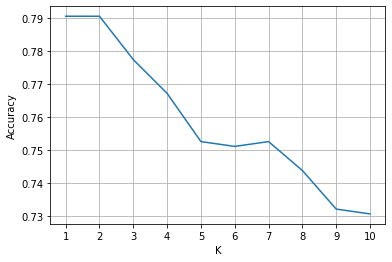

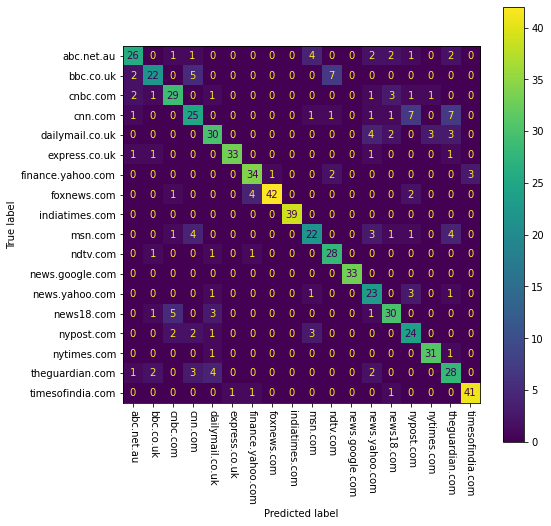

In [12]:
#knn_f1 = joblib.load('output_models/knn_f1.sav')
knn_f1 = knn_classifier(X_train, Y_train, X_test, Y_test, plot=True, verbose=True)
joblib.dump(knn_f1, "output_models/knn_f1.sav")
model_test(knn_f1, X_test, Y_test)

On the test set: accuracy = 0.9472913616398243


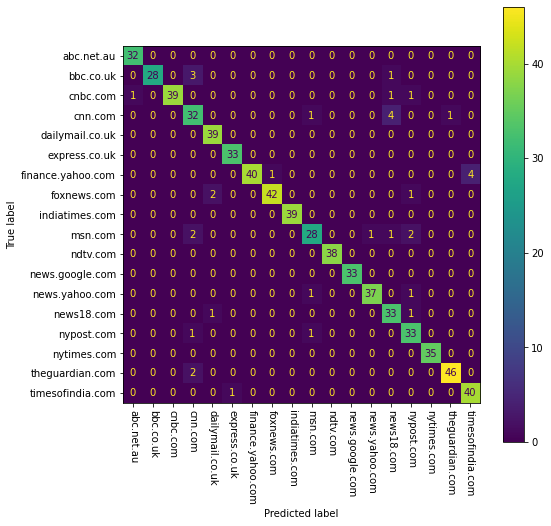

In [13]:
#rf_f1 = joblib.load('output_models/rf_f1.sav')
rf_f1 = random_forest_classifier(X_train, Y_train, X_test, Y_test)
joblib.dump(rf_f1, "output_models/rf_f1.sav")
model_test(rf_f1, X_test, Y_test)

On the test set: accuracy = 0.828696925329429


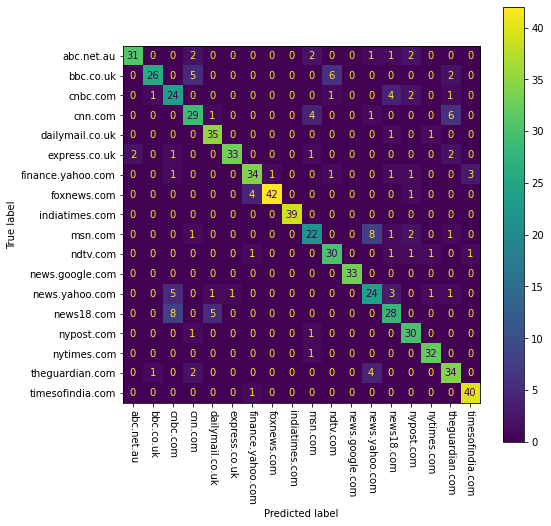

In [14]:
#mlp_f1 = joblib.load("output_models/mlp_f1.sav")
mlp_f1 = multi_layer_perceptron_classifier(X_train, Y_train, X_test, Y_test)
joblib.dump(mlp_f1, "output_models/mlp_f1.sav")
model_test(mlp_f1, X_test, Y_test)

Accuracy with c = 2048 and gamma = 0.125 : 0.8857979502196194
Accuracy with c = 2048 and gamma = 0.5 : 0.8418740849194729
Accuracy with c = 2048 and gamma = 2 : 0.7584187408491947
Accuracy with c = 2048 and gamma = 8 : 0.5080527086383602
Accuracy with c = 8192 and gamma = 0.125 : 0.8857979502196194
Accuracy with c = 8192 and gamma = 0.5 : 0.8418740849194729
Accuracy with c = 8192 and gamma = 2 : 0.7584187408491947
Accuracy with c = 8192 and gamma = 8 : 0.5080527086383602
Accuracy with c = 32768 and gamma = 0.125 : 0.8857979502196194
Accuracy with c = 32768 and gamma = 0.5 : 0.8418740849194729
Accuracy with c = 32768 and gamma = 2 : 0.7584187408491947
Accuracy with c = 32768 and gamma = 8 : 0.5080527086383602
Accuracy with c = 131072 and gamma = 0.125 : 0.8857979502196194
Accuracy with c = 131072 and gamma = 0.5 : 0.8418740849194729
Accuracy with c = 131072 and gamma = 2 : 0.7584187408491947
Accuracy with c = 131072 and gamma = 8 : 0.5080527086383602
Best accuracy  0.8857979502196194 wi

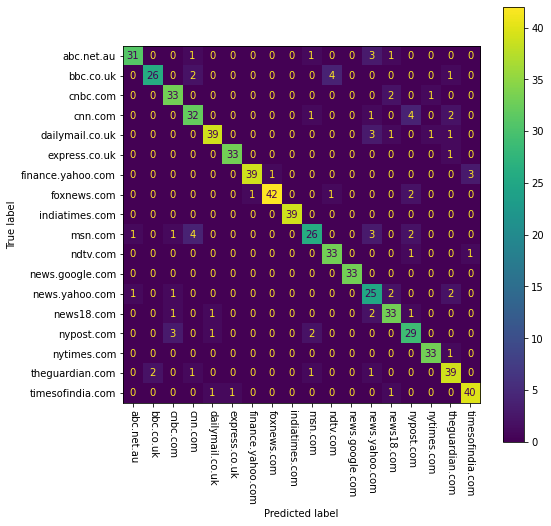

In [15]:
#svm_f1 = joblib.load("output_models/svm_f1.sav")
svm_f1 = svm_classifier(X_train, Y_train, X_test, Y_test, verbose=True)
joblib.dump(svm_f1, "output_models/svm_f1.sav")
model_test(svm_f1, X_test, Y_test)

Now we move to testing in different days. Let's load the model and, if necessary, download the complete CSVs before pre-processing.

In [27]:
knn_f1 = joblib.load('output_models/knn_f1.sav')
rf_f1 = joblib.load('output_models/rf_f1.sav')
mlp_f1 = joblib.load('output_models/mlp_f1.sav')
svm_f1 = joblib.load('output_models/svm_f1.sav')

scaler = joblib.load('output_models/scaler_f1')

In [23]:
#!wget "https://polimi365-my.sharepoint.com/:u:/g/personal/10526141_polimi_it/Ed0xg5e-IN9PmcbDB7tkPWoBq24hpAwaD1eEuraBstraGw?download=1" -O "TEST/firefox.zip"
#!unzip "TEST/firefox.zip" -d "TEST/"




K-NN:  On the test set: accuracy = 0.6890595009596929
RF:    On the test set: accuracy = 0.9021113243761996
MLP:   On the test set: accuracy = 0.7485604606525912
SVM:   On the test set: accuracy = 0.8061420345489443


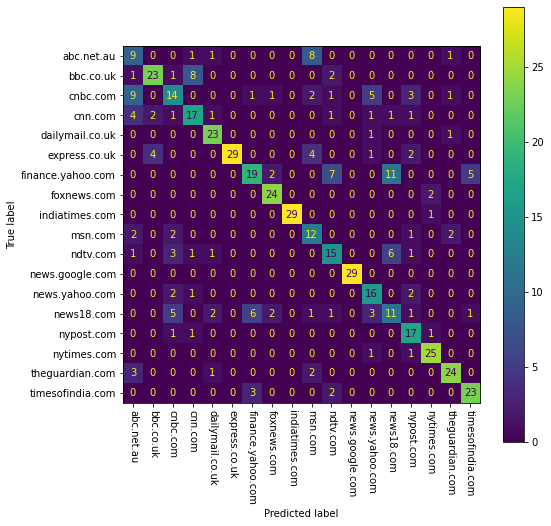

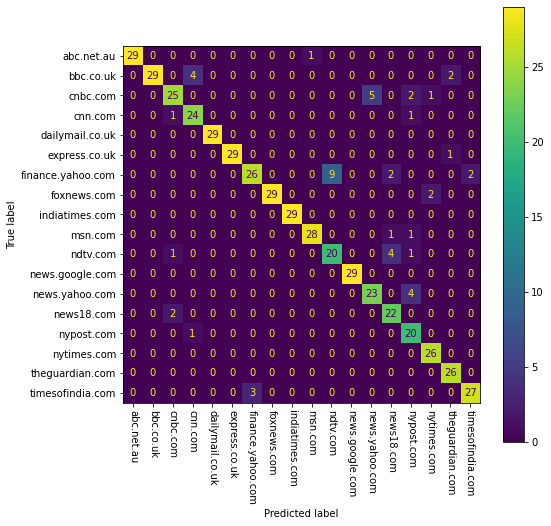

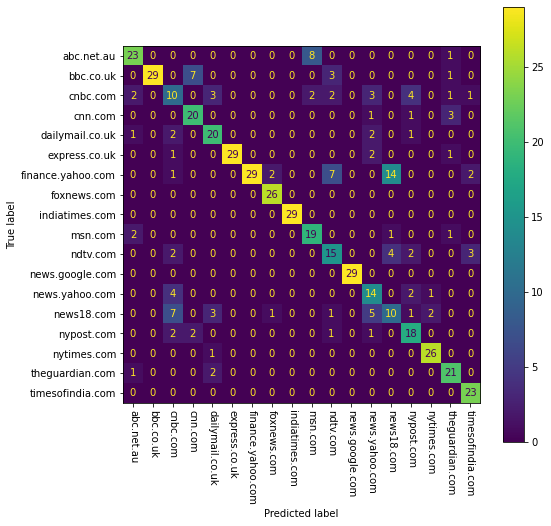

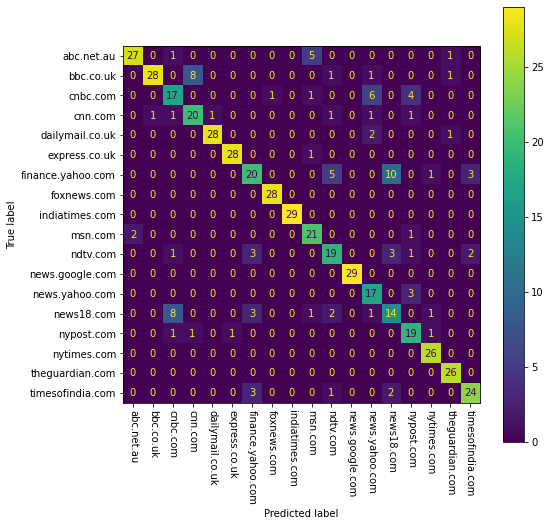

In [28]:
# 1 day later
#dataset = import_csv_biflow('TEST/firefox/1DAY')
#dataset.to_csv('TEST/test_biflow_firefox_1day.csv', index=False)
dataset = pd.read_csv('TEST/test_biflow_firefox_1day.csv')
websites = np.unique(dataset['website'])

X_norm, Y, le = label_encoding(dataset)
X_norm = scaler.transform(X_norm)

print("\n\n")

print("K-NN: ", end = " ")
model_test(knn_f1, X_norm, Y)
print("RF:   ", end = " ")
model_test(rf_f1, X_norm, Y)
print("MLP:  ", end = " ")
model_test(mlp_f1, X_norm, Y)
print("SVM:  ", end = " ")
model_test(svm_f1, X_norm, Y)




K-NN:  On the test set: accuracy = 0.1839080459770115
RF:    On the test set: accuracy = 0.31992337164750956
MLP:   On the test set: accuracy = 0.2222222222222222
SVM:   On the test set: accuracy = 0.19157088122605365


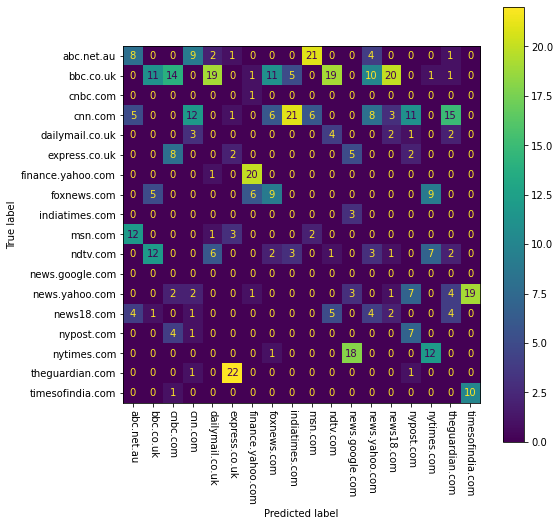

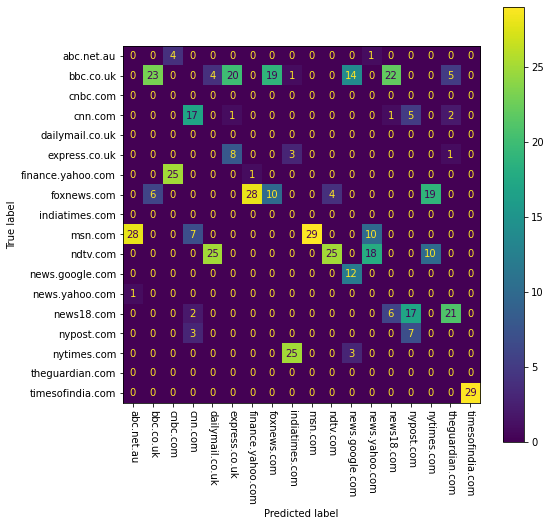

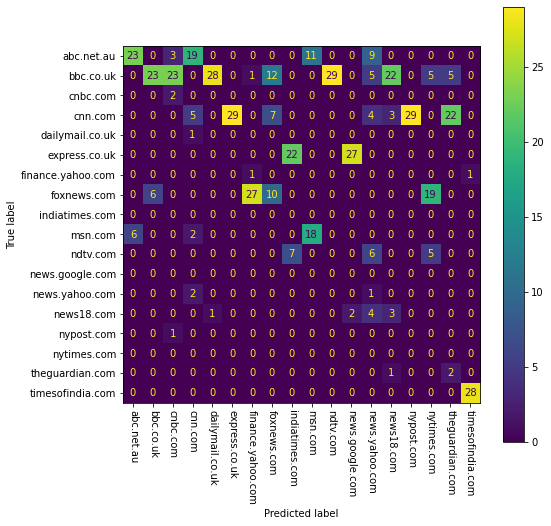

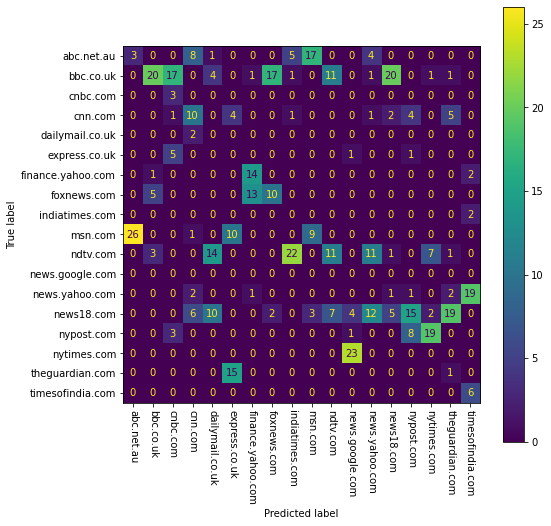

In [29]:
# 3 days later
#dataset = import_csv_biflow('TEST/firefox/3DAYS')
#dataset.to_csv('TEST/test_biflow_firefox_3days.csv', index=False)
dataset = pd.read_csv('TEST/test_biflow_firefox_3days.csv')
websites = np.unique(dataset['website'])

X_norm, Y, le = label_encoding(dataset)
X_norm = scaler.transform(X_norm)

print("\n\n")

print("K-NN: ", end = " ")
model_test(knn_f1, X_norm, Y)
print("RF:   ", end = " ")
model_test(rf_f1, X_norm, Y)
print("MLP:  ", end = " ")
model_test(mlp_f1, X_norm, Y)
print("SVM:  ", end = " ")
model_test(svm_f1, X_norm, Y)

Since accuracy drops a lot, it does not make much sense to test the Biflow classifiers based on Firefox after 7 days.

Such low performance are very strange: while it was clear that there would be a huge drop, this seems excessive.
I may hypothesize that most of the impact comes from the different connection used to perform tests (previous test were done on GARR network in Milan, the 3-DAY dataset was obtained using a residential Eolo connection in my hometown).

## Conclusions
<a id='conclusions'></a>

Generically speaking, accuracy some days after decreseas in all scenarios. This makes sense, since websites are frequently updated. However, there is not a huge drop in all curl captures. Curl downloads only the html file (without images and javascripts) and do not connect to external CDNs normally used to provide content. This means that, on the average, the same features are extracted in more days (the size of the html page, for example, is probably similar even considering different walls of text).
In addition to that, using a very big dataset (more than 400 captures for website) and on different days allows our classifier to be more robust againt new data.

BIFLOW works well on curl traces and on Firefox ones, with the exclusion of those obtained three days later but with the caveaut of the different connection.
This indicates that the biflow approach is sensible to latency, an important fraction of the features in the dataset (all values linked to interarrival times), even after normalizing.
Probably the values found by the fitter are correct for a high speed, very low latency connection (GARR, 1-2 ms to the core network) but are wrong for others connection with higher latency (Eolo, around 15-20 ms to the core network).